In [1]:
#import sys
#!{sys.executable} -m pip install sklearn-pandas

import numpy as np
import pandas as pd
import os
import re

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import randint

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import SimpleImputer

from sklearn_pandas import CategoricalImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.linear_model import LinearRegression

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
medianAge = np.nanmedian(train_data["Age"])
medianAge

28.0

In [6]:
ticket_text = re.findall(r"(?i)\b[a-z]+\b", train_data["Ticket"].to_string())
ticket_textset = set(ticket_text)
ticket_textset

{'A',
 'AH',
 'Basle',
 'C',
 'CA',
 'E',
 'F',
 'Fa',
 'LINE',
 'O',
 'OQ',
 'P',
 'PARIS',
 'PC',
 'PP',
 'Paris',
 'Q',
 'S',
 'SC',
 'SCO',
 'SO',
 'SOTON',
 'STON',
 'SW',
 'W',
 'WE'}

In [7]:
num_attribs = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Sex", "Embarked"]

In [8]:
j_SibSp, j_Parch = [list(num_attribs).index(col) for col in ("SibSp", "Parch")]

In [9]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [10]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_relatives = True):
        self.add_relatives = add_relatives
    def fit(self, X, y = None):
        return self
    def transform(self, X, y=None):
        if self.add_relatives:
            Relatives = X[:, j_SibSp] + X[:, j_Parch]
            return np.c_[X, Relatives]

In [11]:
fancy_title_list = ["Sir.", "Lady.", "Count.", "Countess.", "Duke.", "Duchess.", "M.", "Mlle.", "\""]
female_title_list = ["Miss.", "Mrs.", "Lady.", "Countess.", "Duchess.", "Mlle."]
child_title_list = ["Master."]

In [12]:
def find_string(X, string_list):
    found_strings = [None]*len(X)
    for string_el in range(0, len(X)):
        if any(x in X[string_el] for x in string_list):
            found_strings[string_el] = 1
        else:
            found_strings[string_el] = 0
    return found_strings

In [13]:
class StringFinder(BaseEstimator, TransformerMixin):
    def __init__(self, find_strings = True):
        self.find_strings = find_strings
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        if self.find_strings:
            FancyTitle = find_string(X, fancy_title_list)
            FemaleTitle = find_string(X, female_title_list)
            ChildTitle = find_string(X, child_title_list)
            return np.c_[FancyTitle, FemaleTitle, ChildTitle]

In [14]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy = "median")),
        ('attr_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [15]:
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', CategoricalImputer(strategy = "most_frequent")),
        ('encoder', OneHotEncoder(sparse = False)),
    ])

In [16]:
str_pipeline = Pipeline([
        ('selector', DataFrameSelector("Name")),
        ('str_finder', StringFinder()),
    ])

In [17]:
pre_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
        ("str_pipeline", str_pipeline),
    ])

In [18]:
x_train = pre_pipeline.fit_transform(train_data)
x_test = pre_pipeline.fit_transform(test_data)

In [19]:
y_train = train_data["Survived"]

In [20]:
titanic_dtr = DecisionTreeRegressor(random_state = 42)
titanic_dtr.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [21]:
dtr_score = cross_val_score(titanic_dtr, x_train, y_train, cv = 10)
dtr_score.mean()

0.09718679398198943

In [22]:
titanic_rfg = RandomForestRegressor(n_estimators = 100, random_state = 42)
titanic_rfg.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [23]:
rfg_score = cross_val_score(titanic_rfg, x_train, y_train, cv = 10)
rfg_score.mean()

0.40058147711352515

In [24]:
titanic_lr = LinearRegression()
titanic_lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [25]:
lr_score = cross_val_score(titanic_lr, x_train, y_train, cv = 10)
lr_score.mean()

0.4134531180589377

In [26]:
titanic_rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
titanic_rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [27]:
rfc_score = cross_val_score(titanic_rfc, x_train, y_train, cv = 10)
rfc_score.mean()

0.8103580751333561

In [28]:
og_rfc_score = rfc_score.mean()

In [29]:
y_pred_rfc = titanic_rfc.predict(x_test)
len(y_pred_rfc)

418

In [30]:
submission = test_data["PassengerId"]
submission = pd.concat([submission, pd.DataFrame(y_pred_rfc)], axis=1)
submission.columns = ["PassengerId",  "Survived"]

In [31]:
submission.to_csv("submissionRFC.csv", index = False)

In [32]:
param_grid = [
        {'n_estimators': [75, 100, 200], 'max_features': [4, 5, 6]},
        {'bootstrap': [False], 'n_estimators': [100, 200], 'max_features': [4, 5, 6]},
    ]

titanic_rfc = RandomForestClassifier(random_state = 42)
grid_search = GridSearchCV(titanic_rfc, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

In [33]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [75, 100, 200], 'max_features': [4, 5, 6]}, {'bootstrap': [False], 'n_estimators': [100, 200], 'max_features': [4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [34]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 200}

In [35]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [36]:
param_distrib = {'n_estimators': randint(low=1, high=1000), 'max_features': randint(low=1, high=8)}

titanic_rfc = RandomForestClassifier(random_state = 42)
random_search = RandomizedSearchCV(titanic_rfc, param_distributions = param_distrib, n_iter = 30, cv = 5, scoring = 'neg_mean_squared_error', random_state = 42)

In [37]:
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000B5BD8D0>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000B5BDB70>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [38]:
random_search.best_params_

{'max_features': 7, 'n_estimators': 436}

In [39]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=436, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [40]:
titanic_rfc = RandomForestClassifier(max_features = 7, n_estimators = 436, random_state = 42)
titanic_rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=436, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [41]:
rfc_score = cross_val_score(titanic_rfc, x_train, y_train, cv = 10)
rfc_score.mean()

0.820508455339916

In [42]:
new_rfc_score = rfc_score.mean()

In [43]:
y_pred_rfc = titanic_rfc.predict(x_test)
len(y_pred_rfc)

418

In [44]:
submission = test_data["PassengerId"]
submission = pd.concat([submission, pd.DataFrame(y_pred_rfc)], axis=1)
submission.columns = ["PassengerId",  "Survived"]

In [45]:
submission.to_csv("submissionRFC_impr.csv", index = False)

In [46]:
titanic_svm = SVC(gamma = "auto")
titanic_svm.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [47]:
svm_score = cross_val_score(titanic_svm, x_train, y_train, cv = 10)
svm_score.mean()

0.8316819884235616

In [48]:
og_svm_score = svm_score.mean()

In [49]:
y_pred_svm = titanic_svm.predict(x_test)
len(y_pred_svm)

418

In [50]:
submission = test_data["PassengerId"]
submission = pd.concat([submission, pd.DataFrame(y_pred_svm)], axis=1)
submission.columns = ["PassengerId",  "Survived"]

In [51]:
submission.to_csv("submissionSVM.csv", index = False)

In [52]:
param_grid = {'C': [10, 15, 20], 'gamma': [0.01, 0.02, 0.03]}

titanic_svm = SVC()
grid_search = GridSearchCV(titanic_svm, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

In [53]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [10, 15, 20], 'gamma': [0.01, 0.02, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [54]:
grid_search.best_params_

{'C': 15, 'gamma': 0.02}

In [55]:
grid_search.best_estimator_

SVC(C=15, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.02, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [56]:
titanic_svm = SVC(C = 15, gamma = 0.02)
titanic_svm.fit(x_train, y_train)

SVC(C=15, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.02, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [57]:
svm_score = cross_val_score(titanic_svm, x_train, y_train, cv = 10)
svm_score.mean()

0.8372749971626376

In [58]:
new_svm_score = svm_score.mean()

In [59]:
y_pred_svm = titanic_svm.predict(x_test)
len(y_pred_svm)

418

In [60]:
submission = test_data["PassengerId"]
submission = pd.concat([submission, pd.DataFrame(y_pred_svm)], axis=1)
submission.columns = ["PassengerId",  "Survived"]

In [61]:
submission.to_csv("submissionSVM_impr.csv", index = False)

In [62]:
PROJECT_ROOT_DIR = r"C:\Users\19673418\Desktop\Repository\ADA874\Kaggle Competition\Titanic"
CHAPTER_ID = "Titanic"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [63]:
models = ["Decision Tree Regressor", "Random Forest Regressor", "Linear Regression", "Random Forest Classifier", "Improved Random Forest Classifier", "Support Vector Machine", "Improved Support Vector Machine"]
model_pos = np.arange(len(models))
model_acc = [dtr_score.mean(), rfg_score.mean(), lr_score.mean(), og_rfc_score, new_rfc_score, og_svm_score, new_svm_score]
model_per = [x*100 for x in model_acc]
model_per

[9.718679398198942,
 40.05814771135252,
 41.34531180589377,
 81.03580751333561,
 82.0508455339916,
 83.16819884235616,
 83.72749971626376]

Saving figure Model Accuracies


<function matplotlib.pyplot.show(*args, **kw)>

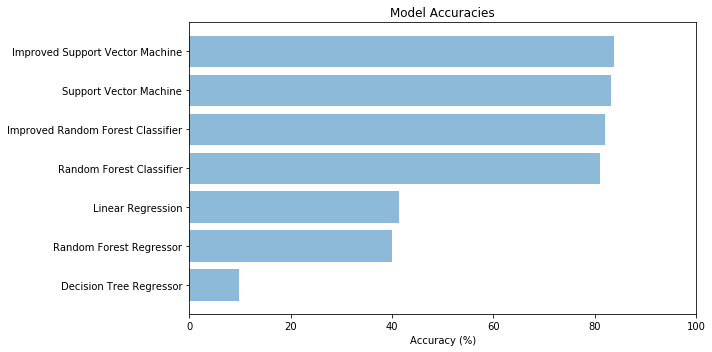

In [64]:
plt.figure(figsize=(10, 5))
plt.barh(model_pos, model_per, align = 'center', alpha = 0.5)
plt.yticks(model_pos, models)
plt.xlabel('Accuracy (%)')
plt.title('Model Accuracies')
axes = plt.gca()
axes.set_xlim([0, 100])
save_fig("Model Accuracies")
plt.show